In [1]:
from typing import List, Set, Dict, Tuple, Optional, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#imports

import warnings
warnings.filterwarnings('ignore')

from nilmtk import DataSet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Lambda, MaxPooling1D
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
#from keras.optimizers import SGD, adam, RMSprop, Nadam, Adadelta
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam, Adadelta
from tensorflow.keras.models import load_model
from keras import backend as K

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from keras.wrappers.scikit_learn import KerasRegressor

#from read_nilmtk import read_data
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters
import pandas as pd
import numpy as np

## Load and Preprocessed Dataset

In [4]:
def load_dataset(filename: str, resample_period :Optional[str]=None) -> pd.DataFrame:
    """
    Loads the dataset
    filename: the path to the file to load
    resample_period: (optional) the reasmple period, if None the default period of 1 second will be used
    returns: a DataFrame containing the dataset
    """
    dataset = pd.read_csv(filename, index_col='datetime').interpolate('linear')
    dataset.index = pd.to_datetime(dataset.index)
    dataset = dataset.asfreq('s')

    if resample_period:
        dataset = dataset.resample(resample_period).nearest()
    
    dataset['hour'] = dataset.index.hour + dataset.index.minute / 60 #+ dataset.index.seconde / 3600

    return dataset

In [5]:
def load_preproc_dataset():
    raw_dataset = pd.read_csv("data/house1_power_blk2_labels.csv", index_col='datetime').interpolate('linear')
    raw_dataset.index = pd.to_datetime(raw_dataset.index)
    raw_dataset = raw_dataset.asfreq('s')

    dataset_resampled = load_dataset("data/house1_power_blk2_labels.csv", "5min")
    dataset_mains_resampled = dataset_resampled["mains"]
    dataset_mains_resampled

    start_time = raw_dataset.index[0]

    #transform to numpy array of 24*356*4 elements
    M = np.array(dataset_mains_resampled)
    lenght = M.shape[0]
    M = M[:-(lenght%24)]
    M = M.reshape(lenght//24,24)

    M = M[~np.all(M == 0, axis=1)]

    M = M.reshape(len(M),24,1)
    for i in range(len(M)):
        M[i] = np.roll(M[i], -start_time.hour)

    #M = preprocessing.normalize(M)
    M = M/(max([max(x) for x in M]))

    U = []
    for x in M:
        RAN = np.array([random.uniform(0, 2) for i in range(24)])
        RAN = np.expand_dims(RAN,axis=1)
        y = x*RAN
        U.append(y)
    V = []
    for x in M:
        RAN = np.array([random.uniform(0, 2) for i in range(24)])
        RAN = np.expand_dims(RAN,axis=1)
        y = x*RAN
        V.append(y)

    for i in range(len(U)):
        U[i] = np.roll(U[i], 8)
        V[i] = np.roll(V[i], -8)

    dada = [0 for i in range(len(M))]
    x_train, x_test, _, __ = train_test_split(M, dada, test_size=0.20)
    u_train, u_test, _, __ = train_test_split(U, dada, test_size=0.20)
    v_train, v_test, _, __ = train_test_split(V, dada, test_size=0.20)

    u_train = np.array(u_train)
    u_test = np.array(u_test)

    return x_train, x_test, u_train, u_test, v_train, v_test 

## Define the AE

In [6]:
def shallow(optimizer='Nadam', loss='categorical_crossentropy', mid_activation='sigmoid', out_activation='sigmoid'):
    
    input_window = Input(shape=(window_length,))
    

    encoded = Dense(latent_size, activation=mid_activation)(input_window)
    
    decoded = Dense(window_length, activation=out_activation)(encoded)

    encoder = Model(input_window, encoded)
    autoencoder = Model(input_window, decoded)

    autoencoder.compile(optimizer=optimizer, loss=loss)

    return autoencoder, encoder

In [7]:
x_train, x_test, x_train_shifted_8, x_test_shifted_8, v_train, v_test  = load_preproc_dataset()
x_train = np.squeeze(x_train, axis=2)
x_test = np.squeeze(x_test, axis=2)
x_train_shifted_8 = np.squeeze(x_train_shifted_8, axis=2)
x_test_shifted_8 = np.squeeze(x_test_shifted_8, axis=2)
v_train = np.squeeze(v_train, axis=2)
v_test = np.squeeze(v_test, axis=2)


#train_set = np.concatenate((x_train,x_train_shifted_8), axis=0)
train_set = x_train
test_set = x_test
pos_shifted_train_set = x_train_shifted_8
pos_shifted_set = x_test_shifted_8
neg_shifted_set = v_test

In [8]:
latent_size = 2
window_length=24
optimizer='Nadam'
loss='categorical_crossentropy'
mid_activation='sigmoid'
out_activation='sigmoid'

In [9]:
autoencoder, encoder = shallow()
autoencoder.fit(train_set, train_set, batch_size=32,
                epochs=200, shuffle=True)

Epoch 1/200
19/19 [==============================] - 1s 2ms/step - loss: 8.6218
Epoch 2/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6202
Epoch 3/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6198
Epoch 4/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6207
Epoch 5/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6233
Epoch 6/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6266
Epoch 7/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6302
Epoch 8/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6344
Epoch 9/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6383
Epoch 10/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6419
Epoch 11/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6456
Epoch 12/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6486
Epoch 13/200
19/19 [=================

19/19 [==============================] - 0s 2ms/step - loss: 8.6482
Epoch 103/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6481
Epoch 104/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6479
Epoch 105/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6477
Epoch 106/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6478
Epoch 107/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6477
Epoch 108/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6477
Epoch 109/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6474
Epoch 110/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6473
Epoch 111/200
19/19 [==============================] - 0s 3ms/step - loss: 8.6472
Epoch 112/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6471
Epoch 113/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6470
Epoch 114/200
19/19 [=========

In [10]:
latent_train = encoder.predict(train_set)
latent_shifted_train = encoder.predict(pos_shifted_train_set)
latent_test = encoder.predict(test_set)
latent_shifted_pos = encoder.predict(pos_shifted_set)

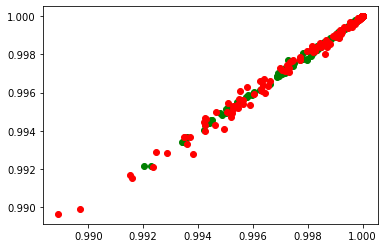

In [11]:
if latent_size == 2:
    X,Y = latent_test.T
    XN,YN = latent_shifted_pos.T
    #XNN,YNN = latent_shifted_neg.T
    plt.plot(X, Y, 'go')
    plt.plot(XN, YN, 'ro')
    #plt.plot(XNN, YNN, 'yo')
elif latent_size ==3:
    from mpl_toolkits.mplot3d import axes3d

    data = (latent_test, latent_shifted_pos,latent_shifted_neg)
    colors = ("green", "red", "yellow")
    groups = ("normal", "anomaly", "anomaly")

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax = fig.gca(projection='3d')


    #X,Y,Z = latent_test.T
    #XN,YN,ZN = latent_shifted_pos.T
    for data, color, group in zip(data, colors, groups):
        x, y, z = data.T
        ax.scatter(x, y, z, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
else:
    pass


In [12]:
def class_preprocess(latent_test, latent_ran_test):
    L = []
    len(L)
    for x in latent_test:
        L.append([x,0])
    for x in latent_ran_test:
        L.append([x,1])

    L = np.array(L)
    np.random.shuffle(L)
    L.shape
    L[0]
    L[1]

    inputs = [x[0] for x in L]
    targets = [x[1] for x in L]
    
    print(x[0])
    
    print("-- Input --")
    print(inputs)
    
    print("\n\n-- Targets --")
    print(targets)

    return inputs, targets

In [13]:
#train
features_matrix_train, labels_train = class_preprocess(latent_train, latent_shifted_train)

#test
features_matrix_test, labels_test = class_preprocess(latent_test, latent_shifted_pos)

0.9974417
-- Input --
[array([0.99948287, 0.9995173 ], dtype=float32), array([0.9953683, 0.9956285], dtype=float32), array([0.9941249 , 0.99386805], dtype=float32), array([0.9984578, 0.9984486], dtype=float32), array([0.99419904, 0.99430525], dtype=float32), array([0.9999894, 0.9999875], dtype=float32), array([0.9996379 , 0.99948907], dtype=float32), array([0.9962627 , 0.99650574], dtype=float32), array([0.99999154, 0.9999919 ], dtype=float32), array([0.999968  , 0.99995714], dtype=float32), array([0.99479806, 0.99442697], dtype=float32), array([0.9999966, 0.9999938], dtype=float32), array([0.9989821 , 0.99872404], dtype=float32), array([0.9954119, 0.99589  ], dtype=float32), array([0.9994029 , 0.99916327], dtype=float32), array([0.9990129, 0.998973 ], dtype=float32), array([0.99999386, 0.99999166], dtype=float32), array([0.99999774, 0.99999785], dtype=float32), array([0.9999108 , 0.99989486], dtype=float32), array([0.9978941, 0.9979005], dtype=float32), array([0.9997121 , 0.99969673],

[array([0.9990139, 0.9989255], dtype=float32), array([0.9942187 , 0.99444246], dtype=float32), array([0.99911064, 0.9991913 ], dtype=float32), array([0.99995136, 0.9999452 ], dtype=float32), array([0.98889613, 0.9896364 ], dtype=float32), array([0.99983704, 0.9998197 ], dtype=float32), array([0.99999624, 0.9999966 ], dtype=float32), array([0.9997852 , 0.99975646], dtype=float32), array([0.99993014, 0.999918  ], dtype=float32), array([0.9999987 , 0.99999785], dtype=float32), array([0.99991924, 0.9999025 ], dtype=float32), array([0.99717176, 0.9972968 ], dtype=float32), array([0.9966302 , 0.99643177], dtype=float32), array([0.99991655, 0.9999176 ], dtype=float32), array([0.99531287, 0.9952556 ], dtype=float32), array([0.9964448, 0.9959992], dtype=float32), array([0.99989337, 0.9998901 ], dtype=float32), array([0.99448895, 0.99453574], dtype=float32), array([0.99818325, 0.99807304], dtype=float32), array([0.99984264, 0.99984974], dtype=float32), array([0.9998733 , 0.99981225], dtype=float

In [14]:
#create and train the random forest classifier
classifier = RandomForestClassifier()
classifier.fit(features_matrix_train, labels_train)

RandomForestClassifier()

In [15]:
#predict and evaluate
predicted_labels_test = classifier.predict(np.array(features_matrix_test))

print(confusion_matrix(labels_test,predicted_labels_test))
print(classification_report(labels_test,predicted_labels_test))

[[81 70]
 [59 92]]
              precision    recall  f1-score   support

           0       0.58      0.54      0.56       151
           1       0.57      0.61      0.59       151

    accuracy                           0.57       302
   macro avg       0.57      0.57      0.57       302
weighted avg       0.57      0.57      0.57       302

